In [1]:
%matplotlib notebook

from rlsm.datasets import load_lawyers
from rlsm import ReciprocityLSM

In [2]:
Y, features = load_lawyers()

In [6]:
model = ReciprocityLSM(n_features=2, reciprocity_type='distance', random_state=42)
model.sample(Y, n_warmup=2500, n_samples=2500)

sample: 100%|█████████████| 5000/5000 [00:36<00:00, 138.36it/s, 63 steps of size 7.10e-02. acc. prob=0.81]


In [8]:
model.print_summary()

AUC: 0.882, WAIC: 3503.081

                  mean       std    median      5.0%     95.0%     n_eff     r_hat
     a_sigma      1.03      0.26      1.01      0.63      1.44    727.03      1.00
    ab_sigma      0.23      0.16      0.22     -0.02      0.48    527.09      1.00
     b_sigma      0.62      0.18      0.60      0.34      0.90    636.58      1.00
   dist_coef      0.06      0.18      0.07     -0.22      0.36    908.06      1.00
  recip_coef     -0.27      0.36     -0.27     -0.85      0.32    859.55      1.00
     u_sigma      1.81      0.15      1.80      1.52      2.03    898.98      1.00

Number of divergences: 14


<IPython.core.display.Javascript object>


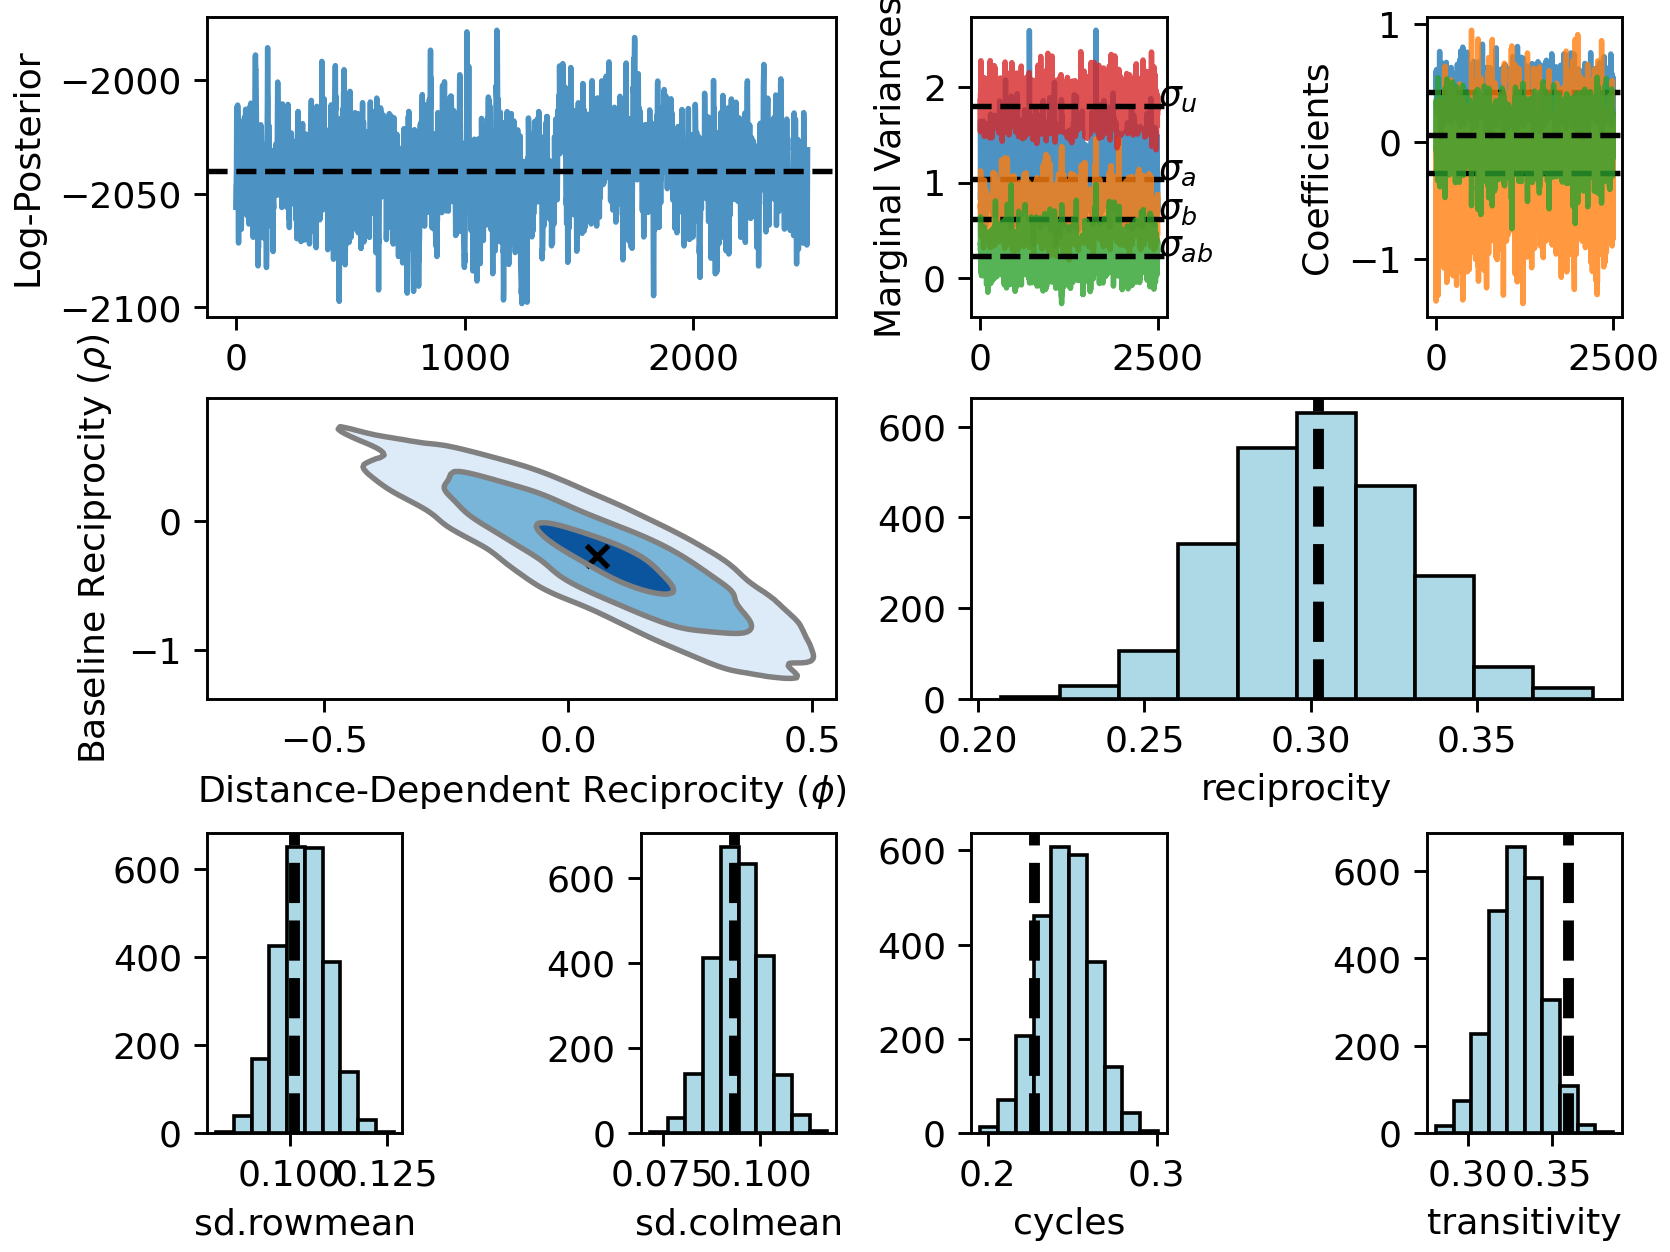

{'A': <Axes: label='A', ylabel='Log-Posterior'>,
 'B': <Axes: label='B', ylabel='Marginal Variances'>,
 'C': <Axes: label='C', ylabel='Coefficients'>,
 'D': <Axes: label='D', xlabel='Distance-Dependent Reciprocity ($\\phi$)', ylabel='Baseline Reciprocity ($\\rho$)'>,
 'E': <Axes: label='E', xlabel='reciprocity'>,
 'F': <Axes: label='F', xlabel='sd.rowmean'>,
 'G': <Axes: label='G', xlabel='sd.colmean'>,
 'H': <Axes: label='H', xlabel='cycles'>,
 'I': <Axes: label='I', xlabel='transitivity'>}

In [7]:
model.plot()

In [10]:
from rlsm.network_utils import adjacency_to_dyads

y_dyads = adjacency_to_dyads(Y, n=Y.shape[0])

In [11]:
from amevb.model_matrix import dyad_cat_diff, dyad_nominal_diff

# dyadic variables (same practice)
X_dyad = np.stack((
    dyad_cat_diff(features['practice']),
    dyad_nominal_diff(features['school']),
    dyad_cat_diff(features['office'])
), axis=2)

In [13]:
import networkx as nx

colors = np.asarray(["tomato", "steelblue", "goldenrod"])
g = nx.from_numpy_array(Y, create_using=nx.DiGraph)
pos = {k : model.U_[k, :2] for k in range(Y.shape[0])}
elist = list(nx.to_edgelist(g))
ecolor = ['darkorange' if Y[e[1], e[0]] else 'black' for e in elist]
nx.draw_networkx(g, pos, 
                 node_color=colors[features['office'].values - 1],
                 edge_color=ecolor, width=0.1, with_labels=False,
                 node_size=50)
plt.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True,
                labelsize=12)